# MODFLOW API Paper

## Optimization of groundwater withdrawals

This notebook can be used to reproduce published results for the "Optimization of groundwater withdrawals" example, as reported in the MODFLOW 6 API paper (in progress).  

## Supported operating systems
This example can be run on the following operating systems:

* linux
* macOS
* Windows


## Prerequisites
To run the simulation and process the results, the following publicly available software and data are required:

* __libmf6.dll__ (Windows) or __libmf6.so__ (linux or MacOS) pre-compiled dynamic-link library (dll)/shared object (so) and available from https://github.com/MODFLOW-USGS/executables. The operating specific pre-compiled dll/so should be installed in the `bin` subdirectory at the same level as the subdirectory containing this Jupyter Notebook (`../bin/`). 
* __mf6.exe__ (Windows) or __mf6__ (linux or MacOS) pre-compiled application and available from https://github.com/MODFLOW-USGS/executables. The operating specific pre-compiled application should be installed in the `bin` subdirectory at the same level as the subdirectory containing this Jupyter Notebook (`../bin/`). 
* __modflowapi__ is an extension to xmipy. __modflowapi__ including an implementation of its abstract methods. The source is available at https://github.com/MODFLOW-USGS/modflowapi and the module can be installed from PyPI using `pip install modflowapi`. __xmipy__ is an extension to bmipy including an implementation of its abstract methods and the source is available at https://github.com/Deltares/xmipy.
* __flopy__ is a python package that can be used to build, run, and post-process MODFLOW 6 models. The source is available at https://github.com/modflowpy/flopy and the package can be installed from PyPI using `pip install flopy` or conda using `conda install flopy`.

## Build the McDonald Valley MODFLOW datasets

* Run the `make_mv.ipynb` notebook prior to running this notebook to build the McDonald Valley datasets needed by this notebook.
    
## Running the simulation

We start by importing the necessary packages:

In [1]:
import os
import sys
import shutil
import numpy as np
import matplotlib.pyplot as plt
import flopy
from modflowapi import ModflowApi

In [2]:
if sys.platform == "win32":
    exe_name = os.path.abspath('../bin/mf6.exe')
    lib_name = os.path.abspath('../bin/libmf6.dll')    
else:
    exe_name = os.path.abspath('../bin/mf6')
    lib_name = os.path.abspath('../bin/libmf6.so')    

In [3]:
ws_original = './mvmodel'
ws = './mvopt'
if os.path.isdir(ws):
    shutil.rmtree(ws)
name = 'mv'

In [4]:
# load the mv-model, change workspace, write and run simulation
sim = flopy.mf6.MFSimulation.load(sim_name=name, 
                                  sim_ws=ws_original, 
                                  exe_name=exe_name,
                                  verbosity_level=0)
sim.set_sim_path(ws)
sim.write_simulation()
sim.run_simulation()

(True, [])

In [5]:
def api_return(success, ws):
    fpth = os.path.join(ws, 'mfsim.stdout')
    errmsg = open(fpth).readlines()
    raise Exception(errmsg)
    
def initialize_mf6lib():
    success = False
    if ws is not None:
        os.chdir(ws)
    mf6_config_file = os.path.join(ws, 'mfsim.nam')
    mf6 = ModflowApi(lib_name)

    # initialize the model
    try:
        mf6.initialize()
    except:
        return api_return(success, ws)
    
    return mf6

def initialize_timestep(mf6):
    dt = mf6.get_time_step()
    mf6.prepare_time_step(dt)
    return

def finalize_timestep(mf6):
    mf6.finalize_time_step()
    
def finalize_mf6lib(mf6):
    success = False
    try:
        mf6.finalize()
        success = True
    except:
        return api_return(success, model_ws)
    

mf6 = initialize_mf6lib()
initialize_timestep(mf6)

In [6]:
def get_results():
    # get pointer to simulated heads
    head_tag = mf6.get_var_address("X", name.upper())
    head = mf6.get_value_ptr(head_tag)
    head = head.reshape((5, 1, 20400))
    bud = None
    spdis = None
    return head, bud, spdis

head, _, _ = get_results()
print(head.shape, head.min(), head.max())

(5, 1, 20400) 11.0 11.0


In [7]:
# simplified function rewritten here for presentation in paper
def run_model(wellq):
    address = ["BOUND", "GWF", "WEL-1"]
    wbtag = mf6.get_var_address(*address)
    bound = mf6.get_value_ptr(wbtag)
    bound[:, 0] = -wellq
    address = ["MXITER", "SLN_1"]
    mxittag = mf6.get_var_address(*address)
    mxit = mf6.get_value_ptr(mxittag)
    kiter = 0
    mf6.prepare_solve(1)
    while kiter < mxit:
        has_converged = mf6.solve(1)
        kiter += 1
        if has_converged:
            break
    if not has_converged:
        return None
    mf6.finalize_solve(1)
    address = ["X", "GWF"]
    htag = mf6.get_var_address(*address)
    head = mf6.get_value_ptr(htag)
    head = head.reshape((5, 1, 20400))
    return head

In [8]:
def run_model(well_rates=None):

    if well_rates is None:
        well_rates = np.array([0, 0, 0])
    well_bound_tag = mf6.get_var_address("BOUND", name.upper(), "WEL_0")
    well_bound_array = mf6.get_value_ptr(well_bound_tag)
    well_bound_array[:, 0] = -well_rates

    mxit_tag = mf6.get_var_address("MXITER", "SLN_1")
    max_iter = mf6.get_value_ptr(mxit_tag)
    
    kiter = 0
    mf6.prepare_solve(1)

    while kiter < max_iter:

        has_converged = mf6.solve(1)
        kiter += 1

        if has_converged:
            msg = "Component {}".format(1) + \
                  " converged in {}".format(kiter) + " outer iterations" + \
                  " out of {}".format(max_iter) + " max iterations"
            #print(msg)
            break

    if not has_converged:
        return api_return(success, ws)

    # finalize solve
    mf6.finalize_solve(1)

    return

run_model(np.array([268000, 67000, 268000]))
head, _, _ = get_results()
print(head.shape, head.min(), head.max())

(5, 1, 20400) -7.706036995585382 11.47513013217813


In [9]:
def make_figure(x=None, plot_layers=(0,)):
    run_model(well_rates=x)
    gwf = sim.get_model(name)
    head, bud, spdis = get_results()
    fig = plt.figure(figsize=(10, 8))
    vmin = head.min()
    vmax = head.max()
    for iplot, k in enumerate(plot_layers):
        ax = fig.add_subplot(1, len(plot_layers), iplot + 1, aspect='equal')
        pmv = flopy.plot.PlotMapView(gwf, ax=ax, layer=k)
        pa = pmv.plot_array(head, vmin=vmin, vmax=vmax, cmap='jet')
        #pmv.plot_grid(colors='white')
        pmv.contour_array(head, linewidths=3.)
        #pmv.plot_specific_discharge(spdis, color='white')
        ax.set_title('Layer {}'.format(k + 1))
        plt.colorbar(pa, shrink=0.5)
    return fig

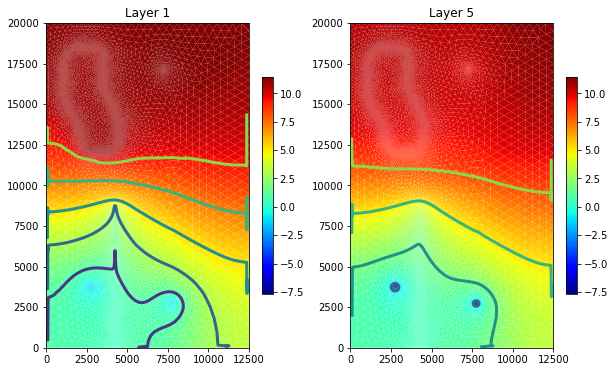

In [10]:
fig = make_figure(x=np.array([268000, 67000, 268000]), plot_layers=[0, 4])

In [11]:
def print_head_constraints(x, head_constraints):
    run_model(well_rates=x)
    head, _, _ = get_results()
    k = head_constraints['layer']
    j = head_constraints['icpl']
    headconsim = head[k, 0, j]
    print('i  headcon  headsim diff')
    for i in range(headcon.shape[0]):
        marker = 'met'
        diff = headconsim[i] - headcon[i]
        if diff < 0:
            marker = '**violated'
        msg = '{} {:.4f} {:.4f} {:.4f} {}'.format(i, headcon[i], headconsim[i], 
                                                  diff, marker)
        print(msg)        
    return

In [12]:
# Define head constraint locations (one-based!)
headcon_lay = [5, 5, 5]
headcon_icpl = [14901, 19668, 20132]
headcon_lay = np.array(headcon_lay) - 1
headcon_icpl = np.array(headcon_icpl) - 1

In [13]:
# Define the head constraints using the base model
#sim = run_model()
#head, _, _ = get_results(sim)
#headcon = head[headcon_lay, headcon_row, headcon_col]
headcon = np.array([1., 10., 1.])
head_constraints = {'layer': headcon_lay,
                    'icpl': headcon_icpl,
                    'head': headcon}

In [14]:
# Print table of whether head constraint was violated or met
nwells = 3
xminmax = np.zeros((2, nwells))
xminmax[1, :] = [268000, 67000, 268000]

print('Using x=xmin')
print_head_constraints(xminmax[0, :], head_constraints)

print('\nUsing x=xmean')
print_head_constraints(xminmax.mean(axis=0), head_constraints)

print('\nUsing x=xmax')
print_head_constraints(xminmax[1, :], head_constraints)

Using x=xmin
i  headcon  headsim diff
0 1.0000 2.6582 1.6582 met
1 10.0000 11.4638 1.4638 met
2 1.0000 5.3425 4.3425 met

Using x=xmean
i  headcon  headsim diff
0 1.0000 -2.0267 -3.0267 **violated
1 10.0000 9.9023 -0.0977 **violated
2 1.0000 -1.1559 -2.1559 **violated

Using x=xmax
i  headcon  headsim diff
0 1.0000 -6.7319 -7.7319 **violated
1 10.0000 8.3413 -1.6587 **violated
2 1.0000 -7.7066 -8.7066 **violated


In [15]:
def forward_model(x, head_constraints):
    run_model(well_rates=x)
    head, _, _ = get_results()
    k = head_constraints['layer']
    j = head_constraints['icpl']
    headconsim = head[k, 0, j]
    return headconsim

def get_rcm(forward_model, x0, constraints, dxmin=10.):
    h0 = forward_model(x0, head_constraints)
    nrow = h0.shape[0]
    ncol = x0.shape[0]
    rcm = np.zeros((nrow, ncol), dtype=np)
    for j in range(ncol):
        xtemp = x0.copy()
        dx = xtemp[j] * 0.10
        if dx == 0.:
            dx = dxmin
        xtemp[j] = xtemp[j] + dx
        h = forward_model(xtemp, constraints)
        ai = (h - h0) / dx
        rcm[:, j] = ai
    return rcm

x0 = xminmax.mean(axis=0)
response_coefficient_matrix = get_rcm(forward_model, x0, 
                                      head_constraints)
nrow, ncol = response_coefficient_matrix.shape
print('Response Coefficient Matrix ({}, {})'.format(nrow, ncol))
for row in response_coefficient_matrix:
    s = ''
    for i in row:
        s += ' {:8.2g}'.format(i)
    print(s)

Response Coefficient Matrix (3, 3)
 -3.3e-05 -3.1e-07 -1.5e-06
 -3.7e-07 -4.1e-05 -1.1e-06
 -1.5e-06 -9.3e-07 -4.7e-05


In [16]:
def solve_linear_optimization(x0, xminmax, constraints):
    # Use Simplex method to solve the optimization problem
    from scipy.optimize import linprog
    xzero = np.zeros(x0.shape, dtype=float)
    h0 = forward_model(xzero, constraints)
    response_coefficient_matrix = get_rcm(forward_model, x0, 
                                          constraints)
    c = -np.ones(x0.shape, dtype=float)
    A = -response_coefficient_matrix
    b = h0 - head_constraints['head']
    xmin = list(xminmax[0, :])
    xmax = list(xminmax[1, :])
    bounds = list(zip(xmin, xmax))
    res = linprog(c, A_ub=A, b_ub=b, bounds=bounds, 
                  method='revised simplex', options={'autoscale': False})
    return res

def solve_nonlinear_optimization(x0, xminmax, constraints, maxiter=5,
                                 theta=1.0, ftol=1., xtol=1.):
    x0 = x0.copy()
    res = solve_linear_optimization(x0, xminmax, constraints)
    if not res.success:
        print('error in first solution. starting x as {}'.format(res.x))
    fold = res.fun
    for i in range(maxiter):
        upgrade = res.x - x0
        x0 = x0 + upgrade * theta
        res = solve_linear_optimization(x0, xminmax, constraints)
        if not res.success:
            print('error in linear optimization for iter {}'.format(i + 1))
            print('setting x to {}'.format(res.x))
        xdiff = res.x - x0
        fdiff = res.fun - fold
        fold = res.fun
        axdm = np.abs(xdiff).max()
        if  abs(fdiff) < ftol and axdm < xtol:
            break
        msg = 'Completed iteration {:4d} obj={:10.4G} fdiff={:10.4G} axdm={:10.4G}'
        msg = msg.format(i + 1, res.fun, fdiff, xdiff.max())
        print(msg)

    print('  fdiff: {}'.format(fdiff))
    print('  axdm: {}'.format(axdm))
    return res

In [17]:
# starting from x0 = xmin
x0 = xminmax.min(axis=0)
print(x0)
res = solve_nonlinear_optimization(x0, xminmax, head_constraints, maxiter=3)
res

[0. 0. 0.]
Completed iteration    1 obj=-1.681E+05 fdiff= 4.349E+05 axdm=-3.369E+04
Completed iteration    2 obj=-1.721E+05 fdiff=     -3997 axdm=      1993
Completed iteration    3 obj=-1.688E+05 fdiff=      3264 axdm=    -770.9
  fdiff: 3263.543900189514
  axdm: 1602.571533025417


     con: array([], dtype=float64)
     fun: -168823.26426716655
 message: 'Optimization terminated successfully.'
     nit: 3
   slack: array([0.00000000e+00, 2.22044605e-16, 0.00000000e+00])
  status: 0
 success: True
       x: array([44975.35865074, 33656.58026029, 90191.32535613])

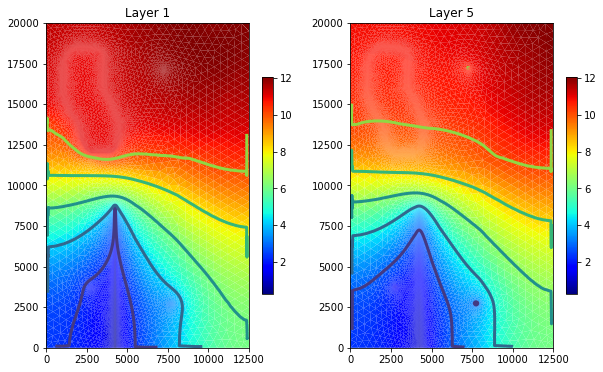

In [18]:
# Plot the results for the optimized pumping rates
fig = make_figure(res.x, plot_layers=[0, 4])

In [19]:
print_head_constraints(res.x, head_constraints)

i  headcon  headsim diff
0 1.0000 1.0102 0.0102 met
1 10.0000 9.9748 -0.0252 **violated
2 1.0000 1.0299 0.0299 met


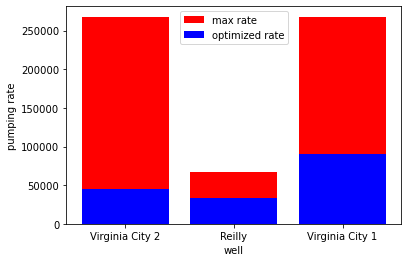

In [20]:
ax = plt.subplot()
labels = ['Virginia City 2', 'Reilly', 'Virginia City 1']
nwells = xminmax.shape[1]
xb = np.arange(nwells)
ax.bar(xb, xminmax[1, :], color='red', label='max rate')
ax.bar(xb, res.x, color='blue', label='optimized rate')
ax.set_xticks(xb)
ax.set_xticklabels(labels)
ax.set_ylabel('pumping rate')
ax.set_xlabel('well')
ax.legend()

In [21]:
finalize_timestep(mf6)
finalize_mf6lib(mf6)

print ('Done...!')

Done...!
